data\SC4001EC-Hypnogram.edf


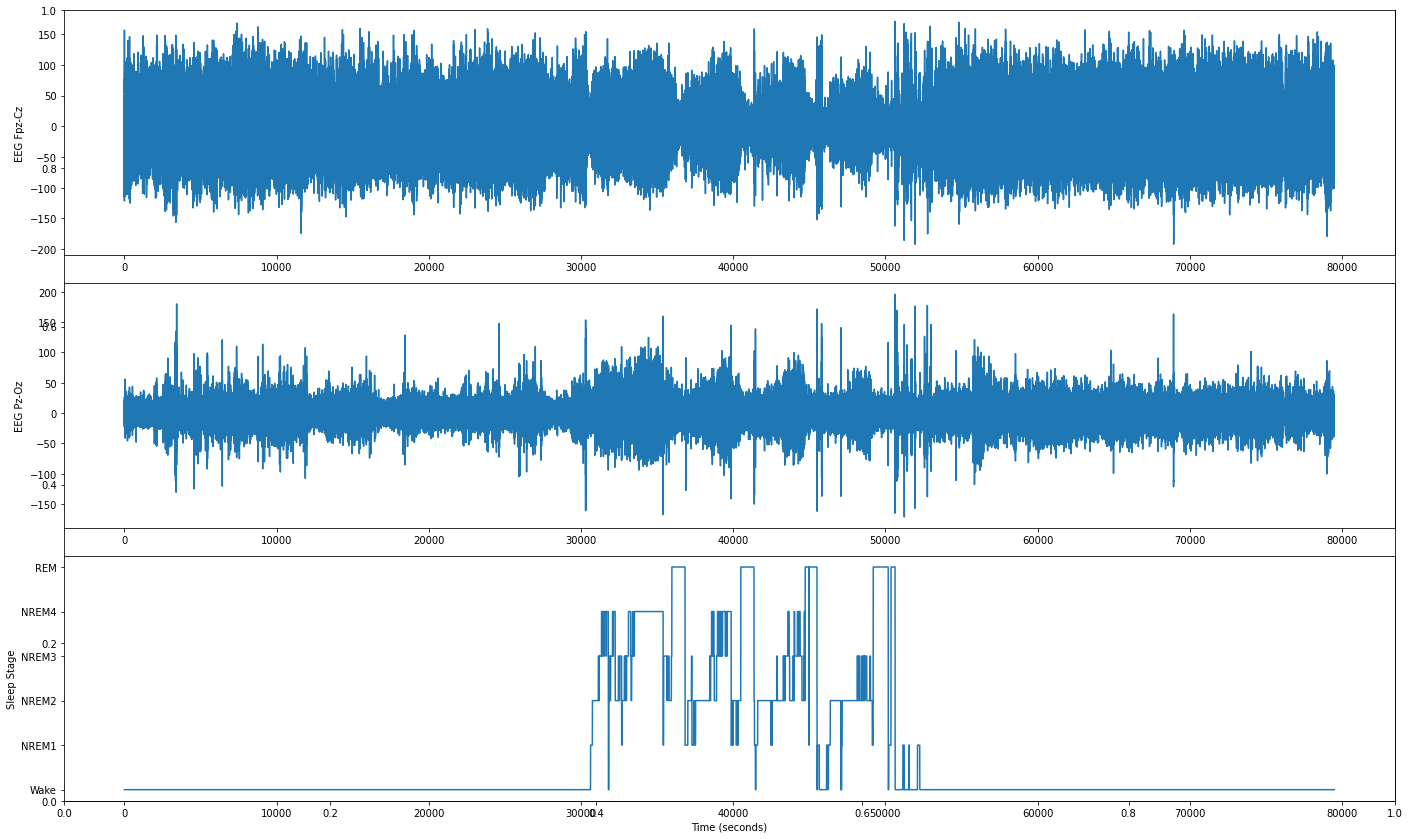

data\SC4002EC-Hypnogram.edf
data\SC4011EH-Hypnogram.edf
data\SC4012EC-Hypnogram.edf
data\SC4021EH-Hypnogram.edf
data\SC4022EJ-Hypnogram.edf
data\SC4031EC-Hypnogram.edf
data\SC4032EP-Hypnogram.edf
data\SC4041EC-Hypnogram.edf
data\SC4042EC-Hypnogram.edf
data\SC4051EC-Hypnogram.edf
data\SC4052EC-Hypnogram.edf
data\SC4061EC-Hypnogram.edf
data\SC4062EC-Hypnogram.edf
data\SC4071EC-Hypnogram.edf
data\SC4072EH-Hypnogram.edf
data\SC4081EC-Hypnogram.edf
data\SC4082EP-Hypnogram.edf
data\SC4091EC-Hypnogram.edf
data\SC4092EC-Hypnogram.edf
data\SC4101EC-Hypnogram.edf
data\SC4102EC-Hypnogram.edf
data\SC4111EC-Hypnogram.edf
data\SC4112EC-Hypnogram.edf
data\SC4121EC-Hypnogram.edf
data\SC4122EV-Hypnogram.edf
data\SC4131EC-Hypnogram.edf
data\SC4141EU-Hypnogram.edf
data\SC4142EU-Hypnogram.edf
data\SC4151EC-Hypnogram.edf
data\SC4152EC-Hypnogram.edf
data\SC4161EC-Hypnogram.edf
data\SC4162EC-Hypnogram.edf
data\SC4171EU-Hypnogram.edf
data\SC4172EC-Hypnogram.edf
data\SC4181EC-Hypnogram.edf
data\SC4182EC-Hypnog

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import pandas as pd
import os
import urllib.request
from pyedflib import highlevel
import glob

"""
Definition of sleep stages:
Wake = 0
N1 = 1
N2 = 2
N3 = 3
N4 = 4
REM = 5
Artifact/Unlabeled: -1
"""

#all EEG data is 100Hz sampling rate
fs = 100

#URL for data
data_url = 'https://archive.physionet.org/physiobank/database/sleep-edfx/'

#define the data directory
data_dir = 'data/'

#make the data directory if it isn't already there
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

#get a list of records and remove newlines
with open('RECORDS.txt') as f: records = f.readlines()
record_names = [r.strip() for r in records]

labeled_data = []
#read each record from the database
for record_name in record_names:
    if record_name.startswith('SC'):
        file_url = '%ssleep-cassette/%s' % (data_url, record_name)
    else:
        file_url = '%ssleep-telemetry/%s' % (data_url, record_name)

    #define the filepath
    filepath = '%s%s' % (data_dir, record_name)

    #download the file if it isn't already downloaded
    # if not os.path.exists(filepath):
    #     print('Downloading %s...' % record_name)
    #     urllib.request.urlretrieve(file_url, filepath)


#get a list of all the hypnogram files
hypnogram_files = glob.glob('%s/*-Hypnogram.edf' % data_dir)
psg_files = glob.glob('%s/*-PSG.edf' % data_dir)
do_plot = True

for f in hypnogram_files:
    print(f)
    hypnogram_filepath = f

    #get the corresponding PSG filepath
    file_id = hypnogram_filepath.split('/')[-1][0:7]
    file_index = [file_id in psg_file for psg_file in psg_files]
    file_index = np.where(np.array(file_index)==True)[0][0]
    psg_filepath = psg_files[file_index]

    #load the files
    try:
        psg_signals, psg_signal_headers, psg_header = highlevel.read_edf(psg_filepath)
        hypnogram_signals, hypnogram_signal_headers, hypnogram_header = highlevel.read_edf(hypnogram_filepath)
    except Exception as e:
        print(str(e))
        continue

    #put into a dataframe
    psg_columns = [psg_signal_headers[i]['label'] for i in range(2)]
    psg_df = pd.DataFrame({psg_columns[0]: psg_signals[0], psg_columns[1]: psg_signals[1]})

    #generate a sample resolution sleep stage label
    sleep_stages = []
    for annotation in hypnogram_header['annotations']:
        #extract the duration in samples of this sleep stage
        dur = int(round(float(annotation[1])))

        sleep_stage = annotation[2][-1]

        #convert the label to the appropriate integer
        if sleep_stage == 'W':
            sleep_stage = 0
        elif sleep_stage == '1':
            sleep_stage = 1
        elif sleep_stage == '2':
            sleep_stage = 2
        elif sleep_stage == '3':
            sleep_stage = 3
        elif sleep_stage == '4':
            sleep_stage = 4
        elif sleep_stage == 'R':
            sleep_stage = 5
        else:
            sleep_stage = -1

        sleep_stages.extend([sleep_stage for i in range(dur*fs)])


    #cut off the psg data at the length of the sleep stage labels
    if len(psg_df) > len(sleep_stages):
        psg_df = psg_df[0:len(sleep_stages)]
    else:
        sleep_stages = sleep_stages[0:len(psg_df)]

    #adding the sleep stages into the df and save the df
    psg_df = psg_df.assign(label=sleep_stages)
    psg_df.to_pickle(hypnogram_filepath.split('-')[0] + '.pkl')
    
    #plot the first file
    if do_plot:
        do_plot = False
        fig, ax = plt.subplots(figsize=(20,12))
        plt.subplot(311)
        t = np.array([i/fs for i in range(len(psg_df))])
        plt.plot(t,psg_df['EEG Fpz-Cz'])
        plt.ylabel('EEG Fpz-Cz')

        plt.subplot(312)
        plt.plot(t, psg_df['EEG Pz-Oz'])
        plt.ylabel('EEG Pz-Oz')

        plt.subplot(313)
        ax = plt.gca()
        plt.plot(t, psg_df['label'])
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['Wake', 'NREM1', 'NREM2', 'NREM3', 'NREM4', 'REM'])
        plt.ylabel('Sleep Stage')
        plt.xlabel('Time (seconds)')
        plt.tight_layout()
        plt.savefig('parsed_data.png', dpi=150)
        plt.show()